# Neo4J v1 - Trellis : Coherence check results (QC)

Coherence check includes results generated by FastQC, Samtools Flagstat, and RTG Vcfstats.

In [4]:
from io import StringIO

import pandas as pd
import pandas_gbq

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from google.cloud import storage
import yaml
import google.datalab.bigquery as bq

### Load Neo4J DB

In [21]:
bucket_info=''
credential_info=''

In [5]:
## Option 1 : Read DB and Account Information in Google Storage (YAML)

# create storage client
storage_client = storage.Client()
# get bucket with name
bucket = storage_client.get_bucket(bucket_inf)
# get bucket data as blob
blob = bucket.get_blob(credential_info)
# convert to string
yaml_data = blob.download_as_string()

account = yaml.load(yaml_data, Loader=yaml.FullLoader)

## Main Account
#graph = Graph(account['NEO4J_SCHEME']+'://'+account['NEO4J_HOST']+":"+str(account['NEO4J_PORT']), auth=(account['NEO4J_USER'],account['NEO4J_PASSPHRASE']))

# FastQC Results (n=285)

## Bigquery table (FastQC)

In [6]:
mvp_fastqc_table=account['GOOGLE_CLOUD_PROJECT']+'.'+account['BIGQUERY_DATASET']+'.fastqc'

## Per base quality

Inserted aggregation function (Average) for per base quality of each sample based on the FastQC results of 25 chromosomes

In [7]:
per_base_qual = bq.Query('SELECT index, value_tenth, ' +
                         'COUNT(*) AS observations ' +
                         'FROM (SELECT sample, index, ' +
                         'ROUND((CAST(value AS FLOAT64)), 1) AS value_tenth, ' +
                         'FROM `' + mvp_fastqc_table + '` ' +
                         'WHERE dimension = "per_base_qual") ' +
                         'GROUP BY index, value_tenth').execute().result().to_dataframe()
#per_base_qual.head()

In [8]:
per_base_qual.head()

,index,value_tenth,observations
0,1,29.9,44
1,1,29.7,21
2,1,29.8,214
3,1,29.5,4
4,1,29.4,1


Divided start point and end point of base quality index  <br />
Changed data type from string to num  <br />
Added log_observation

In [9]:
start_end = pd.DataFrame(per_base_qual['index'].str.split('-',1).tolist(), columns=['start', 'end'])
per_base_qual = per_base_qual.join(start_end)

per_base_qual[['value_tenth']] = per_base_qual[['value_tenth']].apply(pd.to_numeric)
per_base_qual[['start']] = per_base_qual[['start']].apply(pd.to_numeric)
per_base_qual[['observations']] = per_base_qual[['observations']].apply(pd.to_numeric)

per_base_qual[['log_observations']] = np.log(per_base_qual[['observations']])
#per_base_qual.head()
#per_base_qual.to_csv('per_base_qual.csv', sep='\t')

Distribution of per base quality

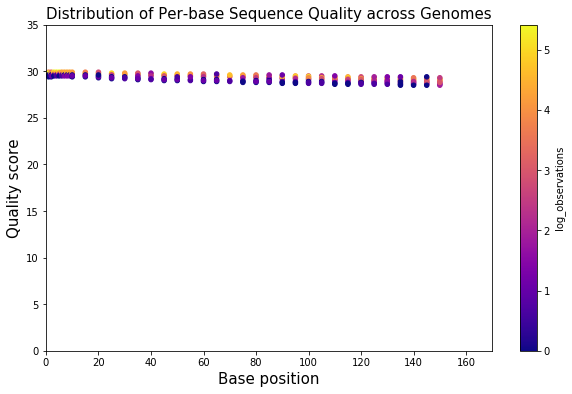

In [10]:
fig, ax = plt.subplots(figsize=(10,6))
scat = per_base_qual.plot(kind='scatter', x='start', y='value_tenth', c='log_observations', cmap='plasma', ax=ax)
ax.set_xlim(0,170)
ax.set_ylim(0,35)
ax.set_title("Distribution of Per-base Sequence Quality across Genomes", size=15)
ax.set_xlabel("Base position", size=15)
ax.set_ylabel("Quality score", size=15)
plt.show()

## GC Content

#### gc_content value

In [11]:
dimension = "gc_content"
gc_content = bq.Query('SELECT sample, CAST(value as INT64) AS GC_value ' + 
                      'FROM `' + mvp_fastqc_table + '` ' +
                      'WHERE dimension = "' + dimension + '"' ).execute().result().to_dataframe()
display(gc_content.shape[0])
#gc_content.head()

285

#### gc_outlier

In [12]:
mean=gc_content.GC_value.mean()
gc_content['gc_outlier'] = gc_content.GC_value.apply(lambda x: False if x in [40,41] else True)

#### To BigQuery table

In [13]:
bq_gc=gc_content.rename(columns={"GC_value":"gc"}).set_index('sample')

#### Distribution of GC content

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:2: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  


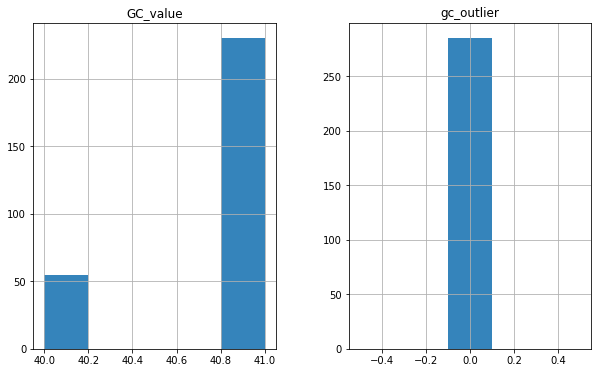

In [14]:
fig, ax = plt.subplots(figsize=(10,6))
gc_content.hist(alpha=0.9, ax=ax, bins=5)
ax.set_xlim(39,42)
#ax.set_ylim(0,250)
ax.set_title("Distribution of Reads GC Content by Genome",size=15)
ax.set_xlabel("GC Content (%)",size=15)
ax.set_ylabel("Frequency",size=15)
plt.show()

## Average sequence quality

#### sum seq_quality

In [15]:
dimension = "seq_quality"
avg_seq_qual = bq.Query('SELECT sample, ' +
                        'SUM(CAST(index as INT64) * CAST(value AS FLOAT64))/SUM(CAST(value AS FLOAT64)) ' + 
                        'FROM `' + mvp_fastqc_table + '` ' + 
                        'WHERE dimension = "' + dimension + '" ' +
                        'GROUP BY sample').execute().result().to_dataframe()

#print(avg_seq_qual.head())

### To BigQuery table

In [16]:
#qc_bq=gc_content.rename(columns={"GC_value":"gc"})
std=avg_seq_qual.f0_.std()
mean=avg_seq_qual.f0_.mean()
#avg_seq_qual['avg_seq_qual_outlier'] = avg_seq_qual.f0_.apply(lambda x: False if abs(mean-x)<3*std else True)
avg_seq_qual['avg_seq_qual_outlier'] = avg_seq_qual.f0_.apply(lambda x: False if x > 28 else True)
bq_avg_seq_qual=avg_seq_qual.rename(columns={"f0_":"avg_seq_qual"}).set_index('sample')

#### statistics of average sequence quality

In [17]:
print('Mean of sequence quality: {0:0.2f}'.format(np.mean(avg_seq_qual.f0_)))
print('Median of sequence quality: {0:0.2f}'.format(np.median(avg_seq_qual.f0_)))
print('STD of sequence quality: {0:0.2f}'.format(np.std(avg_seq_qual.f0_)))
avg_seq_qual.head()
avg_seq_qual.shape[0]

Mean of sequence quality: 29.01
Median of sequence quality: 29.05
STD of sequence quality: 0.12


285

In [18]:
avg_seq_qual['avg_seq_qual_outlier'].value_counts()

False    285
Name: avg_seq_qual_outlier, dtype: int64

#### Distribution of average sequence quality

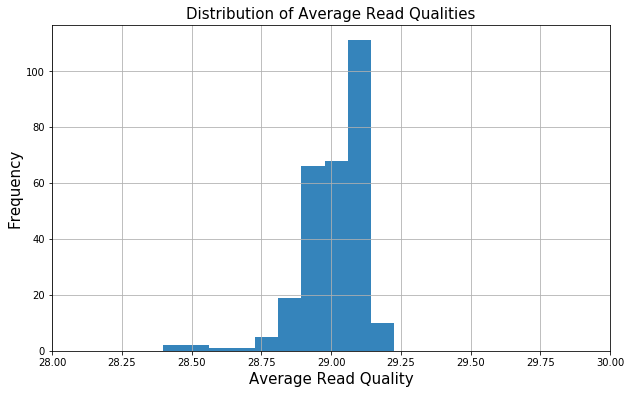

In [19]:
fig, ax = plt.subplots(figsize=(10,6))
avg_seq_qual.f0_.hist(alpha=0.9, ax=ax)
ax.set_xlim(28,30)
ax.set_title("Distribution of Average Read Qualities",size=15)
ax.set_xlabel("Average Read Quality",size=15)
ax.set_ylabel("Frequency",size=15)
plt.show()

## Sequence length

In [20]:
dimension = "seq_len"
seq_len = bq.Query('SELECT sample, dimension, ' +
                   'CAST(value AS INT64) as value '
                   'FROM `' + mvp_fastqc_table + '` ' + 
                   'WHERE dimension = "' + dimension + '"').execute().result().to_dataframe()
#seq_len.head()
seq_len.shape[0]

285

In [21]:
seq_len_counts = seq_len.groupby('value')['sample'].nunique()
print (seq_len_counts)

value
150    285
Name: sample, dtype: int64


In [22]:
seq_len['seq_len_outlier'] = seq_len.value.apply(lambda x: False if x == 150 else True)

Distribution of sequence length

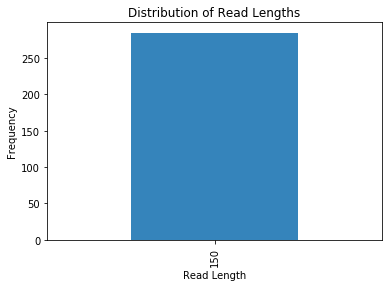

In [23]:
fig, ax = plt.subplots()
bar = seq_len_counts.plot.bar(alpha=0.9)
ax.set_title("Distribution of Read Lengths")
ax.set_xlabel("Read Length")
ax.set_ylabel("Frequency")
plt.show()

### To BigQuery table

In [24]:
bq_seq_len=seq_len.loc[:,['sample','value','seq_len_outlier']].rename(columns={"value":"seq_len"}).set_index('sample')

# VCFStats Results (n=288)

### Bigquery table

In [25]:
mvp_vcfstats_table = account['GOOGLE_CLOUD_PROJECT']+'.'+account['BIGQUERY_DATASET']+'.vcfstats'

## SNPs per genome

The number of samples <br />

In [26]:
snps = bq.Query('SELECT sample, dimension, ' +
                'CAST(value AS INT64) as value ' +
                'FROM `' + mvp_vcfstats_table + '` ' +
                'WHERE dimension = "snps" ').execute().result().to_dataframe()
#print(snps.head())
print('The number of samples: '+str(snps.shape[0]))

The number of samples: 288


Statistics : mean, std, outliers

In [27]:
std=snps.value.std()
mean=snps.value.mean()
print('mean: {0},  std: {1}'.format(round(mean,2), round(std,2)))

# if the measurement is 3 times STD from the mean, then flag it
snps['Outlier'] = snps.value.apply(lambda x: False if abs(mean-x)<3*std else True)
print('The number of outliers: {0}'.format(snps[snps.Outlier].shape[0]))
print(snps[snps.Outlier])

mean: 4555957.02,  std: 379400.78
The number of outliers: 1
        sample dimension    value  Outlier
0  SHIP5125869      snps  3208161     True


Distribution of SNPs

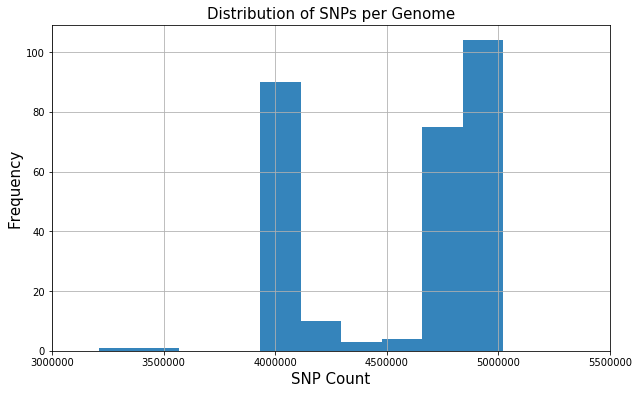

In [28]:
fig, ax = plt.subplots(figsize=(10,6))
hist = snps.value.hist(alpha=0.9, ax=ax, bins=10)
ax.set_xlim(3000000,5500000)
ax.set_title("Distribution of SNPs per Genome",size=15)
ax.set_xlabel("SNP Count",size=15)
ax.set_ylabel("Frequency",size=15)
plt.show()
#plt.savefig('Distribution of SNPs per Genome.png')

### To BigQuery table

In [29]:
bq_snps=snps.loc[:,['sample','value','Outlier']]. \
    rename(columns={"value":"snps","Outlier":"snps_outlier"}).set_index('sample')

## Check number of variants in each category

In [30]:
dimension_sums = bq.Query('SELECT dimension, SUM(CAST(value AS INT64)) AS sum ' +
                'FROM `' + mvp_vcfstats_table + '` ' +
                'WHERE dimension IN ("failed_filters", "passed_filters") ' +
                'GROUP BY dimension').execute().result().to_dataframe()
dimension_sums.head()

,dimension,sum
0,failed_filters,0
1,passed_filters,142148812946


## Indels per genome

In [31]:
dimension1 = "indels"
dimension2 = "insertions"
dimension3 = "deletions"

indels = bq.Query('SELECT sample, ' +
                  'SUM(CAST(value AS INT64)) as value ' +
                  'FROM `' + mvp_vcfstats_table + '` ' +
                  'WHERE (dimension = "' + dimension1 + '") OR (dimension = "' + dimension2 + '") OR (dimension = "' + dimension3 + '")' +
                  'GROUP BY sample').execute().result().to_dataframe()
#indels.head()

In [32]:
#fig, ax = plt.subplots()
#hist = indels.hist(alpha=0.5, ax=ax)
#ax.set_title("Distribution of INDELs per Genome")
#ax.set_xlabel("INDEL Count")
#ax.set_ylabel("Frequency")
#plt.show()

In [33]:
#box = indels.plot.box()

In [34]:
#plt.figure()
#plt.boxplot(indels['value'], 0, 'gD')
#plt.show()

## Cumulative insertions, deletions, and indels
RTG Tools vcfstats outputs data on three categories of indels: insertions, deletions, and indels. From this google group post (https://groups.google.com/a/realtimegenomics.com/forum/#!searchin/rtg-users/vcfstats/rtg-users/-eFsSbWF6ks/1HrnevHTAgAJ):

>For the insertions/deletions/indels the table is based on the delta in length rather than total length (which really matters for the indels):

>Insertions (pure addition of bases)
>A -> AT (length 1 insertion)
>ATT -> ATTTT (length 2 insertion) 

>Deletions (pure deletion of bases)
>AT -> A (length 1 deletion)
>ATTTT -> ATT (length 2 deletion)

>Indels (length changing but not pure)
>ATT -> CTTT (length 1 indel)
>CTTT -> ATT (length 1 indel)"

In [35]:
indels = bq.Query('SELECT sample, SUM(DISTINCT CAST(value AS INT64)) AS cum_indels ' +
                  'FROM `' + mvp_vcfstats_table + '` ' +
                  'WHERE dimension = "insertions" ' +
                  'OR dimension = "deletions" ' +
                  'OR dimension = "indels" ' +
                  'GROUP BY sample').execute().result().to_dataframe()
#indels.head()

Statistics : mean, std, outliers

In [36]:
std=indels.cum_indels.std()
mean=indels.cum_indels.mean()
print('mean: {0},  std: {1}'.format(round(mean,2), round(std,2)))

# if the measurement is 3 times STD from the mean, then flag it
indels['Outlier'] = indels.cum_indels.apply(lambda x: False if abs(mean-x)<3*std else True)
print('The number of outliers: {0}'.format(indels[indels.Outlier].shape[0]))
print(indels[indels.Outlier])

mean: 1054097.66,  std: 80489.14
The number of outliers: 1
         sample  cum_indels  Outlier
91  SHIP5125869      802776     True


Distribution of indels

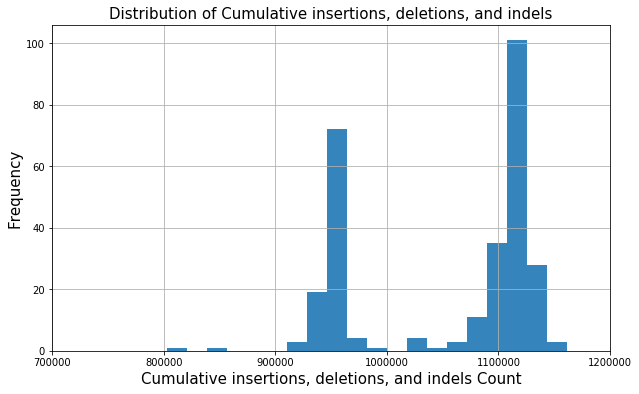

In [37]:
fig, ax = plt.subplots(figsize=(10,6))
hist = indels.cum_indels.hist(alpha=0.9, ax=ax, bins = 20)
ax.set_xlim(700000,1200000)
ax.set_title("Distribution of Cumulative insertions, deletions, and indels",size=15)
ax.set_xlabel("Cumulative insertions, deletions, and indels Count",size=15)
ax.set_ylabel("Frequency",size=15)
plt.show()

#### To BigQuery table

In [38]:
bq_indels=indels.rename(columns={"cum_indels":"indels","Outlier":"indels_outlier"}).set_index('sample')

## Frequency of Ti/Tv ratios

In [39]:
dimension = "ti_tv_ratio"
ti_tv = bq.Query('SELECT sample, dimension, ' + 
                 'CAST(value AS FLOAT64) as value ' + 
                 'FROM `' + mvp_vcfstats_table + '` ' + 
                 'WHERE dimension = "' + dimension + '"').execute().result().to_dataframe()

#### Outlier table

In [40]:
mean=ti_tv.value.mean()
display(mean)
ti_tv['ti_tv_outlier'] = ti_tv.value.apply(lambda x: False if abs(mean-x)<3*std else True)

1.9408680555555557

Distribution of Ti/Tv

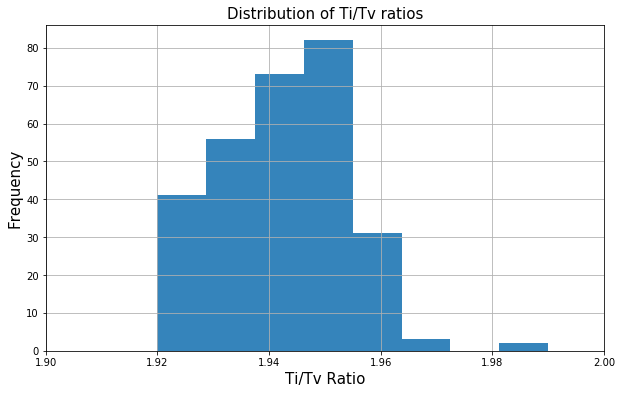

In [41]:
fig, ax = plt.subplots(figsize=(10,6))
hist = ti_tv.value.hist(alpha=0.9, ax=ax, bins=8)
ax.set_xlim(1.9,2.0)
ax.set_title("Distribution of Ti/Tv ratios",size=15)
ax.set_xlabel("Ti/Tv Ratio",size=15)
ax.set_ylabel("Frequency",size=15)
plt.show()

### To BigQuery table

In [42]:
bq_ti_tv=ti_tv.loc[:,['sample','value','ti_tv_outlier']]. \
    rename(columns={"value":"ti_tv"}).set_index('sample')

In [43]:
#plt.figure()
#plt.boxplot(ti_tv['value'], 0, 'gD')
#plt.show()

## Frequency of SNP het/hom ratios

In [44]:
snp_het_hom_ratio = bq.Query('SELECT sample, dimension, ' + 
                             'CAST(value AS FLOAT64) as value ' + 
                             'FROM `' + mvp_vcfstats_table + '` ' + 
                             'WHERE dimension = "snp_het_hom_ratio"').execute().result().to_dataframe()
#snp_het_hom_ratio.head()

Statistics : mean, std, outliers

In [45]:
std=snp_het_hom_ratio.value.std()
mean=snp_het_hom_ratio.value.mean()
print('mean: {0},  std: {1}'.format(round(mean,2), round(std,2)))

# if the measurement is 3 times STD from the mean, then flag it
snp_het_hom_ratio['Outlier'] = snp_het_hom_ratio.value.apply(lambda x: False if abs(mean-x)<3*std else True)
print('The number of outliers: {0}'.format(snp_het_hom_ratio[snp_het_hom_ratio.Outlier].shape[0]))
print(snp_het_hom_ratio[snp_het_hom_ratio.Outlier])

mean: 1.94,  std: 0.23
The number of outliers: 2
        sample          dimension  value  Outlier
0  SHIP5125869  snp_het_hom_ratio   0.96     True
1  SHIP5125862  snp_het_hom_ratio   1.21     True


Distribution of SNP het/hom

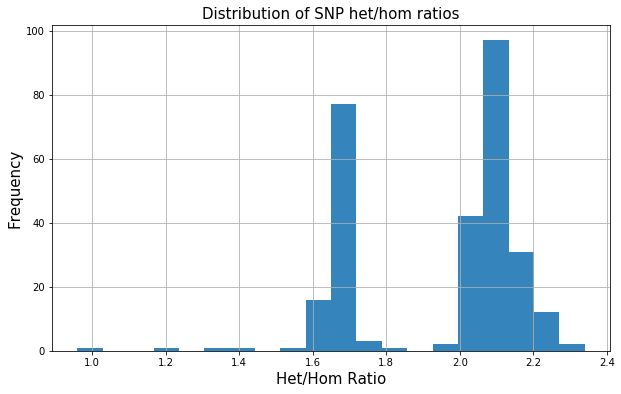

In [46]:
fig, ax = plt.subplots(figsize=(10,6))
hist = snp_het_hom_ratio.value.hist(alpha=0.9, ax=ax, bins=20)
ax.set_title("Distribution of SNP het/hom ratios",size=15)
ax.set_xlabel("Het/Hom Ratio",size=15)
ax.set_ylabel("Frequency",size=15)
plt.show()

### To BigQuery table

In [47]:
bq_het_hom=snp_het_hom_ratio.loc[:,['sample','value','Outlier']]. \
    rename(columns={"value":"het_hom","Outlier":"het_hom_outlier"}).set_index('sample')

# Samtools Flagstat Results (n=286)

In [48]:
mvp_flagstat_table = account['GOOGLE_CLOUD_PROJECT']+'.'+account['BIGQUERY_DATASET']+'.flagstat'

## Count and Percent of reads mapped to reference

In [49]:
dimension = "qc_passed_reads_count"
qc_passed_reads_count = bq.Query('SELECT sample, ' + 
                             'CAST(value AS FLOAT64) as total_count, ' +
                             'FROM `' + mvp_flagstat_table + '` ' + 
                             'WHERE dimension = "' + dimension + '"').execute().result().to_dataframe()
print('The number of samples: '+str(qc_passed_reads_count.shape[0]))

The number of samples: 286


In [50]:
dimension = "mapped_reads_count"
mapped_reads_count = bq.Query('SELECT sample, ' + 
                             'CAST(value AS FLOAT64) as mapped_count ' + 
                             'FROM `' + mvp_flagstat_table + '` ' + 
                             'WHERE dimension = "' + dimension + '"').execute().result().to_dataframe()

In [51]:
mapped_reads_perc=qc_passed_reads_count.set_index(['sample']).join(mapped_reads_count.set_index(['sample']))
mapped_reads_perc['mapped_perc']=100*(mapped_reads_perc['mapped_count']/mapped_reads_perc['total_count'])
mapped_reads_perc['total_count']=mapped_reads_perc.total_count.astype(int)
mapped_reads_perc['mapped_count']=mapped_reads_perc.mapped_count.astype(int)
mapped_reads_perc['mapped_perc']=mapped_reads_perc.mapped_perc.astype(float).round(2)

#print('Mean of mapped_reads: {0:0.2f}'.format(np.mean(mapped_reads_perc.mapped_perc)))
#print('Median of mapped_reads: {0:0.2f}'.format(np.median(mapped_reads_perc.mapped_perc)))
#print('STD of mapped_reads: {0:0.2f}'.format(np.std(mapped_reads_perc.mapped_perc)))
#mapped_reads_perc.head()

Statistics : Mean, STD, the number of samples with less than 99% mapped percent 

In [52]:
std=mapped_reads_perc.mapped_perc.std()
mean=mapped_reads_perc.mapped_perc.mean()
print('mean: {0},  std: {1}'.format(round(mean,2), round(std,2)))

# if the measurement is 3 times STD from the mean, then flag it
#mapped_reads_perc['Outlier'] = mapped_reads_perc.mapped_perc.apply(lambda x: False if abs(mean-x)<3*std else True)
mapped_reads_perc['Outlier'] = mapped_reads_perc.mapped_perc.apply(lambda x: False if x > 98 else True)

print('The number of samples in < 98% : {0}'.format(mapped_reads_perc[mapped_reads_perc.Outlier].shape[0]))
#print('The number of outlier samples : {0}'.format(mapped_reads_perc[mapped_reads_perc.Outlier].shape[0]))
print(mapped_reads_perc[mapped_reads_perc.Outlier])

mapped_count_outlier = mapped_reads_perc[['mapped_perc','Outlier']]
mapped_count_outlier.sort_values(by=['mapped_perc'],inplace=True)
#print(mapped_count_outlier[mapped_count_outlier.Outlier])

mean: 99.81,  std: 0.02
The number of samples in < 98% : 0
Empty DataFrame
Columns: [total_count, mapped_count, mapped_perc, Outlier]
Index: []


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Distribution of Mapped Reads

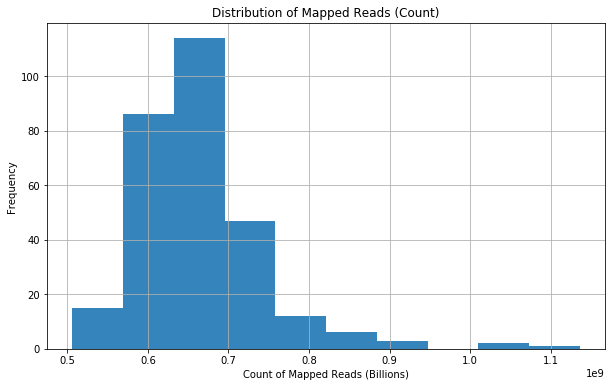

In [53]:
fig, ax = plt.subplots(figsize=(10,6))
hist = mapped_reads_perc.mapped_count.hist(alpha=0.9, ax=ax)
ax.set_title("Distribution of Mapped Reads (Count)")
ax.set_xlabel("Count of Mapped Reads (Billions)")
ax.set_ylabel("Frequency")
plt.show()

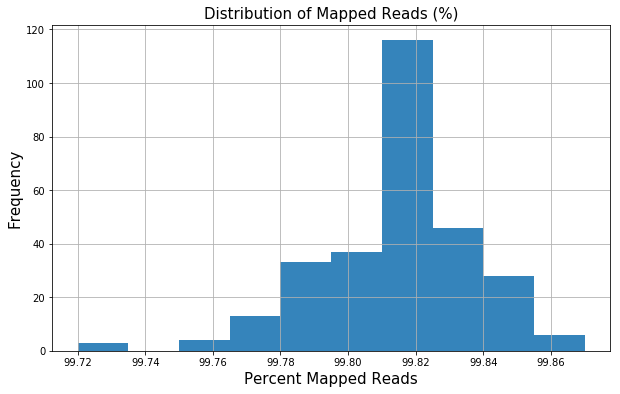

In [54]:
fig, ax = plt.subplots(figsize=(10,6))
hist = mapped_reads_perc.mapped_perc.hist(alpha=0.9, ax=ax)
ax.set_title("Distribution of Mapped Reads (%)",size=15)
ax.set_xlabel("Percent Mapped Reads",size=15)
ax.set_ylabel("Frequency",size=15)
plt.show()

### To BigQuery table

In [55]:
bq_mapped_pct=mapped_reads_perc.loc[:,['mapped_perc','Outlier']]. \
    rename(columns={"mapped_perc":"mapped_pct","Outlier":"mapped_pct_outlier"})


## Count and Percent of reads properly paired

In [56]:
dimension = "properly_paired_count"
properly_paired_count = bq.Query('SELECT sample, ' + 
                             'CAST(value AS FLOAT64) as mapped_count ' 
                             'FROM `' + mvp_flagstat_table + '` ' + 
                             'WHERE dimension = "' + dimension + '"').execute().result().to_dataframe()


In [57]:
properly_paired_perc=qc_passed_reads_count.set_index(['sample']).join(properly_paired_count.set_index(['sample']))
properly_paired_perc['mapped_perc']=100*(properly_paired_perc['mapped_count']/properly_paired_perc['total_count'])
properly_paired_perc['total_count']=properly_paired_perc.total_count.astype(int)
properly_paired_perc['mapped_count']=properly_paired_perc.mapped_count.astype(int)
properly_paired_perc['mapped_perc']=properly_paired_perc.mapped_perc.astype(float).round(2)

#print('Mean of properly_paired: {0:0.2f}'.format(np.mean(properly_paired_perc.mapped_perc)))
#print('Median of properly_paired: {0:0.2f}'.format(np.median(properly_paired_perc.mapped_perc)))
#print('STD of properly_paired: {0:0.2f}'.format(np.std(properly_paired_perc.mapped_perc)))
#properly_paired_perc.head()

Statistics : Mean, STD, the number of samples with less than 96% properly paired percent 

In [58]:
std=properly_paired_perc.mapped_perc.std()
mean=properly_paired_perc.mapped_perc.mean()
print('mean: {0},  std: {1}'.format(round(mean,2), round(std,2)))

# if the measurement is 3 times STD from the mean, then flag it
# properly_paired_perc['Outlier'] = properly_paired_perc.mapped_perc.apply(lambda x: False if abs(mean-x)<3*std else True)
properly_paired_perc['Outlier'] = properly_paired_perc.mapped_perc.apply(lambda x: False if x > 96 else True)
#display(properly_paired_perc.head())
properly_paired_perc = properly_paired_perc[['mapped_count','mapped_perc','Outlier']]
properly_paired_perc.sort_values(by=['mapped_perc'],inplace=True)
print('The number of samples in < 96% : {0}'.format(properly_paired_perc[properly_paired_perc.Outlier].shape[0]))
print(properly_paired_perc[properly_paired_perc.Outlier])

mean: 96.74,  std: 0.23
The number of samples in < 96% : 1
             mapped_count  mapped_perc  Outlier
sample                                         
SHIP5141894     703416651        95.98     True


Distribution of properly paired reads

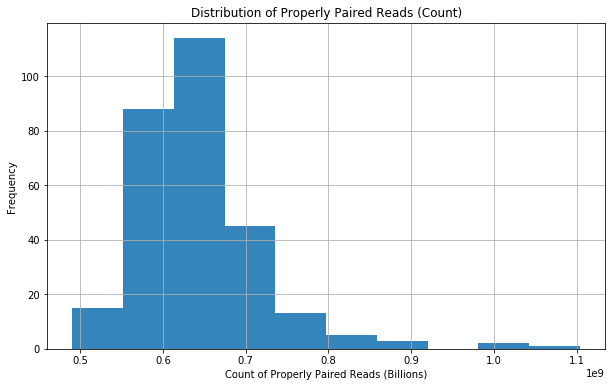

In [59]:
fig, ax = plt.subplots(figsize=(10,6))
hist = properly_paired_perc.mapped_count.hist(alpha=0.9, ax=ax)
ax.set_title("Distribution of Properly Paired Reads (Count)")
ax.set_xlabel("Count of Properly Paired Reads (Billions)")
ax.set_ylabel("Frequency")
plt.show()

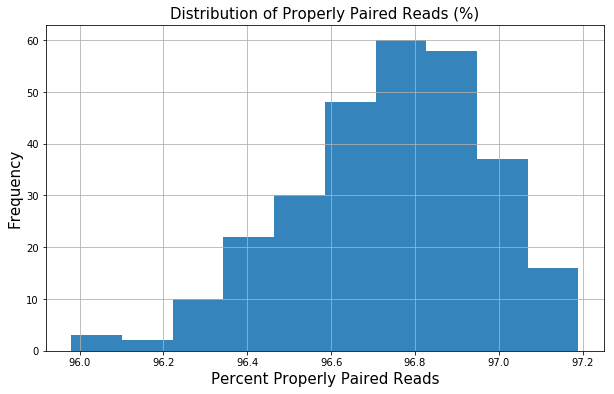

In [60]:
fig, ax = plt.subplots(figsize=(10,6))
hist = properly_paired_perc.mapped_perc.hist(alpha=0.9, ax=ax)
ax.set_title("Distribution of Properly Paired Reads (%)",size=15)
ax.set_xlabel("Percent Properly Paired Reads",size=15)
ax.set_ylabel("Frequency",size=15)
plt.show()

### To BigQuery table

In [61]:
bq_paired_pct=properly_paired_perc.loc[:,['mapped_perc','Outlier']]. \
    rename(columns={"mapped_perc":"paired_pct","Outlier":"paired_pct_outlier"})

# VerifyBamID Results (n=288)

In [62]:
mvp_verifybamid_table = account['GOOGLE_CLOUD_PROJECT']+'.'+account['BIGQUERY_DATASET']+'.check_contamination'

In [63]:
check_contamination = bq.Query('SELECT SEQ_ID, ' + 'CAST(FREEMIX AS FLOAT64) as contamination_rate ' 
                             'FROM `' + mvp_verifybamid_table + '` ').execute().result().to_dataframe()

In [64]:
print('The number of samples : ' + str(len(check_contamination)))

The number of samples : 288


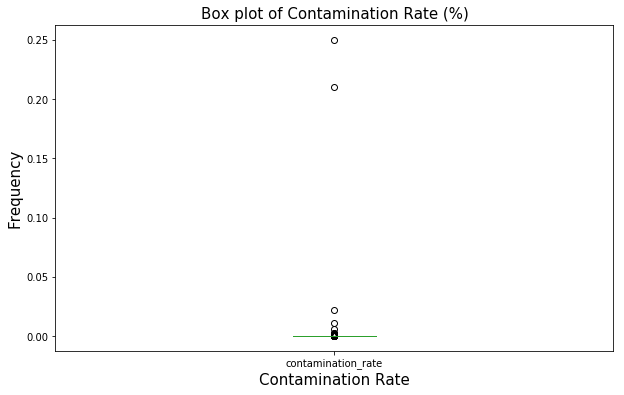

In [65]:
fig, ax = plt.subplots(figsize=(10,6))
hist = check_contamination.contamination_rate.plot.box(ax=ax)
ax.set_title("Box plot of Contamination Rate (%)",size=15)
ax.set_xlabel("Contamination Rate",size=15)
ax.set_ylabel("Frequency",size=15)
plt.show()

/usr/local/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0, 0.5, 'Frequency')

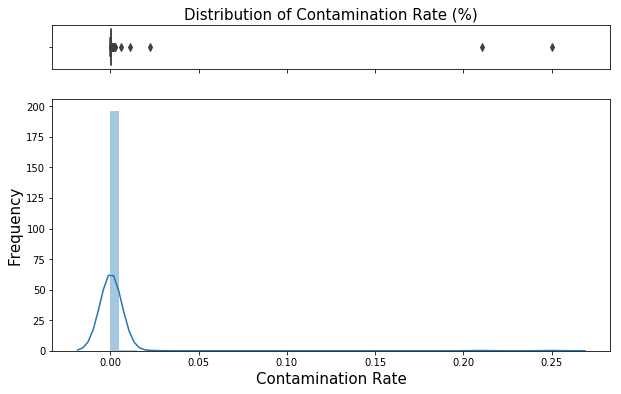

In [66]:
# Cut the window in 2 parts
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)}, figsize=(10,6))
 
# Add a graph in each part
sns.boxplot(check_contamination["contamination_rate"], ax=ax_box)
sns.distplot(check_contamination["contamination_rate"], ax=ax_hist)
 
# Remove x axis name for the boxplot
ax_box.set(xlabel='')
ax_box.set_title("Distribution of Contamination Rate (%)",size=15)
ax_hist.set_xlabel("Contamination Rate",size=15)
ax_hist.set_ylabel("Frequency",size=15)


### To BigQuery table

In [67]:
bq_contam=check_contamination.rename(columns={"SEQ_ID":"sample","contamination_rate":"contam_rate"}).set_index('sample')

bq_contam.loc[bq_contam.contam_rate < 0.05, 'contam_rate_outlier']=False
bq_contam.loc[bq_contam.contam_rate >= 0.05, 'contam_rate_outlier']=True

#bq_contam.head()

# BigQuery Table

### Merge all QC features

In [68]:
bq_qc=bq_gc.merge(bq_avg_seq_qual, how='outer',left_index=True,right_index=True) \
    .merge(bq_seq_len, how='outer',left_index=True,right_index=True) \
    .merge(bq_snps, how='outer',left_index=True,right_index=True) \
    .merge(bq_indels, how='outer',left_index=True,right_index=True) \
    .merge(bq_ti_tv, how='outer',left_index=True,right_index=True) \
    .merge(bq_het_hom, how='outer',left_index=True,right_index=True) \
    .merge(bq_mapped_pct, how='outer',left_index=True,right_index=True) \
    .merge(bq_paired_pct, how='outer',left_index=True,right_index=True) \
    .merge(bq_contam, how='outer',left_index=True,right_index=True)
bq_qc.reset_index(inplace=True)

### Add outlier list

In [69]:
## pass
bq_qc['outlier']='pass'

## fail check
bq_qc.loc[(bq_qc['gc_outlier']==True)|(bq_qc['avg_seq_qual_outlier']==True)|(bq_qc['seq_len_outlier']==True) \
          |(bq_qc['snps_outlier']==True)|(bq_qc['indels_outlier']==True)|(bq_qc['ti_tv_outlier']==True) \
          |(bq_qc['het_hom_outlier']==True)|(bq_qc['mapped_pct_outlier']==True)|(bq_qc['paired_pct_outlier']==True) \
          |(bq_qc['contam_rate_outlier']==True),'outlier']='outlier'

## outlier
bq_qc.loc[(bq_qc['gc_outlier'].isna())|(bq_qc['avg_seq_qual_outlier'].isna())|(bq_qc['seq_len_outlier'].isna()) \
          |(bq_qc['snps_outlier'].isna())|(bq_qc['indels_outlier'].isna())|(bq_qc['ti_tv_outlier'].isna()) \
          |(bq_qc['het_hom_outlier'].isna())|(bq_qc['mapped_pct_outlier'].isna())|(bq_qc['paired_pct_outlier'].isna()) \
          |(bq_qc['contam_rate_outlier'].isna()),'outlier']='uncompleted'

### Drop duplicate

In [70]:
bq_qc.drop_duplicates(keep='first',inplace=True)

### Outlier and uncompleted lists

In [71]:
bq_qc.loc[bq_qc['outlier']=='outlier',:].to_csv('gs://gbsc-gcp-project-mvp-test-trellis/analysis-notebooks/qc_outlier-v058-1.csv')
bq_qc.loc[bq_qc['outlier']=='uncompleted',:].to_csv('gs://gbsc-gcp-project-mvp-test-trellis/analysis-notebooks/qc_uncompleted-v058-1.csv')

### Upload DF to BigQuery

In [72]:
table_id=account['BIGQUERY_DATASET']+'.qc_analysis'
projectid=account['GOOGLE_CLOUD_PROJECT']

pandas_gbq.to_gbq(
    bq_qc, table_id, project_id=projectid, if_exists='replace',
)

1it [00:04,  4.80s/it]
